# Assignment 1

## Question `2` (Decision Trees)

| | |
|-|-|
| Course | Statistical Methods in AI |
| Release Date | `19.01.2023` |
| Due Date | `29.01.2023` |

This assignment will have you working and experimenting with decision trees. Initially, you will be required to implement a decision tree classifier by choosing thresholds based on various impurity measures and reporting the scores. Later, you can experiment with the `scikit-learn` implementation of decision trees, and how various other parameters can be leveraged for better performance.

The dataset is a very simple one, the [banknote authentication dataset](https://archive.ics.uci.edu/ml/datasets/banknote+authentication). It has 5 columns, the first 4 are the features, and the last one is the class label. The features are the variance, skewness, curtosis and entropy of the [wavelet transformed](https://en.wikipedia.org/wiki/Wavelet_transform) image of the banknote. The class label is 1 if the banknote is authentic, and 0 if it is forged. The data is present in `bankAuth.txt`. There are a total of 1372 samples in the dataset.

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import math
from sklearn.metrics import accuracy_score

### Impurity Measures

Decision trees are only as good as the impurity measure used to choose the best split. In this section, you will be required to implement the following impurity measures and use them to build a decision tree classifier.

1. Gini Index
2. Entropy
3. Misclassification Error
4. Log Loss

Write functions that calculate the impurity measures for a given set of labels. The functions should take in a list of labels and return the impurity measure.

In [2]:
#Gini Index Implementation
def gini(labels):
    classes, counts = np.unique(labels, return_counts=True)
    gini = 1 - np.sum((counts/np.sum(counts))**2)
    return gini

#Entropy implementation
def entropy(labels):
    classes, counts = np.unique(labels, return_counts=True)
    entropy = -np.sum((counts/np.sum(counts))*np.log2(counts/np.sum(counts)))
    return entropy

#Log Loss implementation
def logloss(labels):
    classes, counts = np.unique(labels, return_counts=True)
    logloss = -np.sum((counts/np.sum(counts))*np.log(counts/np.sum(counts)))
    return logloss

#Misclassification Error Implementation
def misclassification_error(labels):
    classes, counts = np.unique(labels, return_counts=True)
    misclassification_error = 1 - np.max(counts/np.sum(counts))
    return misclassification_error

### Decision Tree

Fit a decision tree using any one of the above impurity measures with a depth of 3. This means you will have eight leaf nodes and seven internal nodes. Report the threshold values at each internal node and the impurity measure at the final leaf node with the label. Also report the accuracy of the classifier on the training and test data (instructions for splitting the data will be given in the end).

In [3]:
class Node:
    def __init__(self=None, feature_index=None, threshold=None, left=None, right=None, gain=None, value=None):
        self.feature_index = feature_index # index of the feature
        self.threshold = threshold # threshold value of the feature 
        self.left = left # left child node
        self.right = right # right child node
        self.gain = gain # information gain of that node 
        self.value = value # value of the node, used for leaf nodes

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=3, entropy=entropy):
        self.min_samples_split = min_samples_split # minimum number of samples for splitting condition
        self.max_depth = max_depth # maximum depth of the tree which is set to 3 as given
        self.root = None # root node 
        self.entropy = entropy # entropy function

    def information_gain(self, parent, left_child, right_child):
        parent_entropy = self.entropy(parent) # entropy of the parent
        left_entropy = self.entropy(left_child) # entropy of the left child 
        right_entropy = self.entropy(right_child) # entropy of the right child
        #information gain
        information_gain = parent_entropy - (left_entropy*len(left_child)/len(parent) + right_entropy*len(right_child)/len(parent))
        return information_gain

    def best_split(self, x, y):
        best_split = {}
        max_information_gain = -math.inf
        for feature_index in range(x.shape[1]):
            feature_values = np.unique(x[:, feature_index])
            for threshold in feature_values:
                left_child = y[x[:, feature_index] <= threshold]
                right_child = y[x[:, feature_index] > threshold]
                #if there is data in the children, then we calculate information gain
                if len(left_child) > 0 and len(right_child) > 0:
                    information_gain = self.information_gain(y, left_child, right_child)
                    if information_gain > max_information_gain: 
                        max_information_gain = information_gain #updating maximum gain
                        best_split['feature_index'] = feature_index
                        best_split['threshold'] = threshold
                        best_split['left_child'] = left_child
                        best_split['right_child'] = right_child
                        best_split['gain'] = information_gain
        return best_split

    def build_tree(self, x, y, depth=0):
        #Condition 1: depth is less than equal to max depth 
        #Condition 2: Number of samples is greater than and equal to the minimum number of samples
        if depth <= self.max_depth and len(y) >= self.min_samples_split:
            best_split = self.best_split(x, y) # calculating best split
            if best_split['gain'] > 0:
                #when gain exists, we initialize a node and build sub-trees
                left_node = self.build_tree(x[x[:, best_split['feature_index']] <= best_split['threshold']], best_split['left_child'], depth+1)
                right_node = self.build_tree(x[x[:, best_split['feature_index']] > best_split['threshold']], best_split['right_child'], depth+1)
                return Node(best_split['feature_index'], best_split['threshold'], left_node, right_node, best_split['gain'])
        #(boundary condition)->NO best split, returning node with the highest freq label
        return Node(value=np.bincount(y).argmax())
    
    def fit(self, x, y):
        self.root = self.build_tree(x, y) #tree building
    
    def predict_sub(self, x, tree):
        if tree.value is not None: #leaf node: directly return
            return tree.value
        if x[tree.feature_index] <= tree.threshold: #if not leaf, return based on threshold value
            return self.predict_sub(x, tree.left)
        else:
            return self.predict_sub(x, tree.right)

    def predict(self, x):
        predictions = []
        for sample in x:
            predictions.append(self.predict_sub(sample, self.root))
        return predictions
    
    def tree_details(self, tree=None, indent = " "):
        if tree.value is not None: #if only leaf node exists
            print(tree.value)
            return
        print("Feature Index: ", tree.feature_index, "Threshold: ", tree.threshold, "Gain: ", tree.gain)
        print(indent, "Left ->", end=" ") #left nodes
        self.tree_details(tree.left, indent + indent)
        print(indent, "Right ->", end=" ") #right nodes
        self.tree_details(tree.right, indent + indent)


### `sklearn` Decision Tree Experiments

1. Scikit-learn has two decision tree implementations: [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) and [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). 

When would you use one over the other? What would you use in the case of the banknote authentication dataset? Explain the changes that need to be made in the dataset to use the other implementation.

2. Fit a decision tree to the training set. Change various parameters and compare them to one another. Mainly try and experiment with the `criterion`, `max_depth` and `min_samples_split` parameters. Report the accuracy on the training and test set for each of the experiments while varying the parameters for comparison purposes.

3. Plot your trees !! (optional) (for visualization)

```python
from sklearn.tree import plot_tree

def plotTree(tree):
    """
    tree: Tree instance that is the result of fitting a DecisionTreeClassifier
          or a DecisionTreeRegressor.
    """
    plt.figure(figsize=(30,20))
    plot_tree(tree, filled=True, rounded=True,
                  class_names=['forged', 'authentic'],
                  feature_names=['var', 'skew', 'curt', 'ent'])
    plt.show()
    return None
```

**Answer to Part 1**

When the target variable is **discrete or categorical** (such as "yes" or "no," "spam" or "not spam," etc.) and you wish to forecast the class of a new observation, you use a `DecisionTreeClassifier`.
A cricket match prediction model that predicts whether a specific team will win or lose is an example of a discrete output.

A `DecisionTreeRegressor`, on the other hand, looks at an object's features and develops a model in the form of a tree to predict future data and **produce useful continuous output**. Because it is not entirely represented by a predetermined set of discrete numbers, the output or outcome is not discrete.
A sales forecasting model that forecasts the profit margins that a company would increase over a financial year based on prior values is an example of continuous output.

Since the **banknote authentication** dataset we are working on is a classification problem with the target variable being 'authentic' or 'not authentic,' we would use `DecisionTreeClassifier`.
We would need to change the target variable into a continuous variable in order to use DecisionTreeRegressor.

In [4]:
"""Using Decision Tree Classifier from sklearn.tree"""
from sklearn.tree import DecisionTreeClassifier

def decision_tree(x_train, y_train, x_test, y_test, criterion, max_depth, min_samples_split):
    clf = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [5]:
from sklearn.tree import plot_tree

def plotTree(tree):
    """
    tree: Tree instance that is the result of fitting a DecisionTreeClassifier
          or a DecisionTreeRegressor.
    """
    plt.figure(figsize=(30,20))
    plot_tree(tree, filled=True, rounded=True,
                  class_names=['forged', 'authentic'],
                  feature_names=['var', 'skew', 'curt', 'ent'])
    plt.show()
    return None

### Load Data

The data has been loaded onto a Pandas DataFrame. Try to get an initial feel for the data by using functions like `describe()`, `info()`, or maybe try to plot the data to check for any patterns.

Note: To obtain the data from the UCI website, `wget` can be used followed by shuffling the samples using `shuf` and adding a header for easier reading via `pandas`. It is not necessary to view the data in a DataFrame and can be directly loaded onto NumPy as convenient.

In [6]:
data = pd.read_csv('bankAuth.txt')
data.head()
print(data.describe())
print(data.info())

            3.6216       8.6661      -2.8073     -0.44699            0
count  1371.000000  1371.000000  1371.000000  1371.000000  1371.000000
mean      0.431410     1.917434     1.400694    -1.192200     0.444931
std       2.842494     5.868359     4.310105     2.101683     0.497139
min      -7.042100   -13.773100    -5.286100    -8.548200     0.000000
25%      -1.774700    -1.711300    -1.553350    -2.417000     0.000000
50%       0.495710     2.313400     0.616630    -0.586650     0.000000
75%       2.814650     6.813100     3.181600     0.394810     1.000000
max       6.824800    12.951600    17.927400     2.449500     1.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371 entries, 0 to 1370
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   3.6216    1371 non-null   float64
 1   8.6661    1371 non-null   float64
 2   -2.8073   1371 non-null   float64
 3   -0.44699  1371 non-null   float64
 4   0         1371 n

In [7]:
y = data.iloc[:,-1]
X = data.iloc[:,:-1]
X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)

(1371, 4)
(1371,)


### Splitting the Data

It is a good practice to split the data into training and test sets. This is to ensure that the model is not overfitting to the training data. The test set is used to evaluate the performance of the model on unseen data. The test set is not used to train the model in any way. The test set is only used to evaluate the performance of the model. You may use the `train_test_split` function from `sklearn.model_selection` to split the data into training and test sets.

It is a good idea to move your data to NumPy arrays now as it will make computing easier.

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1096, 4)
(275, 4)
(1096,)
(275,)


### Denouement

Use this place to report all comparisons and wrap up the calls to the functions written above.

`Using Decision Tree From Scratch`

In [9]:
model = DecisionTree()
model.fit(X_train, y_train)
train_preds = model.predict(X_train) #On train data
test_preds = model.predict(X_test) #On test data
print("Accuracy of Decision tree manually implemented on Train Data: ", accuracy_score(y_train, train_preds))
print("Accuracy of Decision tree manually implemented on Test Data: ", accuracy_score(y_test, test_preds))

Accuracy of Decision tree manually implemented on Train Data:  0.9835766423357665
Accuracy of Decision tree manually implemented on Test Data:  0.9672727272727273


In [10]:
print(model.tree_details(model.root))

Feature Index:  0 Threshold:  0.31803 Gain:  0.40305465006891683
  Left -> Feature Index:  1 Threshold:  5.8333 Gain:  0.2854200505006889
   Left -> Feature Index:  2 Threshold:  6.2169 Gain:  0.08534972474373662
     Left -> Feature Index:  1 Threshold:  4.0537 Gain:  0.016959219058717497
         Left -> 1
         Right -> 1
     Right -> Feature Index:  1 Threshold:  -4.7428 Gain:  0.5670434462677704
         Left -> 1
         Right -> 0
   Right -> Feature Index:  0 Threshold:  -4.1479 Gain:  0.7903974924100984
     Left -> Feature Index:  2 Threshold:  1.0836 Gain:  0.205592508185083
         Left -> 1
         Right -> 0
     Right -> 0
  Right -> Feature Index:  0 Threshold:  1.7875 Gain:  0.1372903997666518
   Left -> Feature Index:  2 Threshold:  -2.2726 Gain:  0.5036441056159237
     Left -> Feature Index:  1 Threshold:  5.2022 Gain:  0.26676498780302604
         Left -> 1
         Right -> 0
     Right -> Feature Index:  2 Threshold:  0.18307 Gain:  0.13992674356715423
   

`Using Decision Tree from SKLEARN`

`On train Data`

In [11]:
criterion = ['gini', 'entropy']
max_depth = [2, 3, 4, 5, 6, 7, 8, 9, 10]
min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9, 10]
accuracies = []
max_accuracy = 0
best_criterion = None
best_depth = None
best_split = None
for crit in criterion:
    for depth in max_depth:
        for split in min_samples_split:
            accuracies.append(decision_tree(X_train, y_train, X_train, y_train, crit, depth, split))
            print("Criterion: ", crit, "\t" ,"Max Depth: ", depth,"\t"  ,"Min Samples Split: " ,split, "\t" , "Accuracy: ", decision_tree(X_train, y_train, X_train, y_train, crit, depth, split))
            if decision_tree(X_train, y_train, X_train, y_train, crit, depth, split) > max_accuracy:
                max_accuracy = decision_tree(X_train, y_train, X_train, y_train, crit, depth, split)
                best_criterion = crit
                best_depth = depth
                best_split = split

print("\n\n")
print("Max Accuracy: ", max_accuracy, "\nBest Criterion: ", best_criterion, "\nBest Depth: ", best_depth, "\nBest Split: ", best_split)

Criterion:  gini 	 Max Depth:  2 	 Min Samples Split:  2 	 Accuracy:  0.9187956204379562
Criterion:  gini 	 Max Depth:  2 	 Min Samples Split:  3 	 Accuracy:  0.9187956204379562
Criterion:  gini 	 Max Depth:  2 	 Min Samples Split:  4 	 Accuracy:  0.9187956204379562
Criterion:  gini 	 Max Depth:  2 	 Min Samples Split:  5 	 Accuracy:  0.9187956204379562
Criterion:  gini 	 Max Depth:  2 	 Min Samples Split:  6 	 Accuracy:  0.9187956204379562
Criterion:  gini 	 Max Depth:  2 	 Min Samples Split:  7 	 Accuracy:  0.9187956204379562
Criterion:  gini 	 Max Depth:  2 	 Min Samples Split:  8 	 Accuracy:  0.9187956204379562
Criterion:  gini 	 Max Depth:  2 	 Min Samples Split:  9 	 Accuracy:  0.9187956204379562
Criterion:  gini 	 Max Depth:  2 	 Min Samples Split:  10 	 Accuracy:  0.9187956204379562
Criterion:  gini 	 Max Depth:  3 	 Min Samples Split:  2 	 Accuracy:  0.9406934306569343
Criterion:  gini 	 Max Depth:  3 	 Min Samples Split:  3 	 Accuracy:  0.9406934306569343
Criterion:  gini 	 M

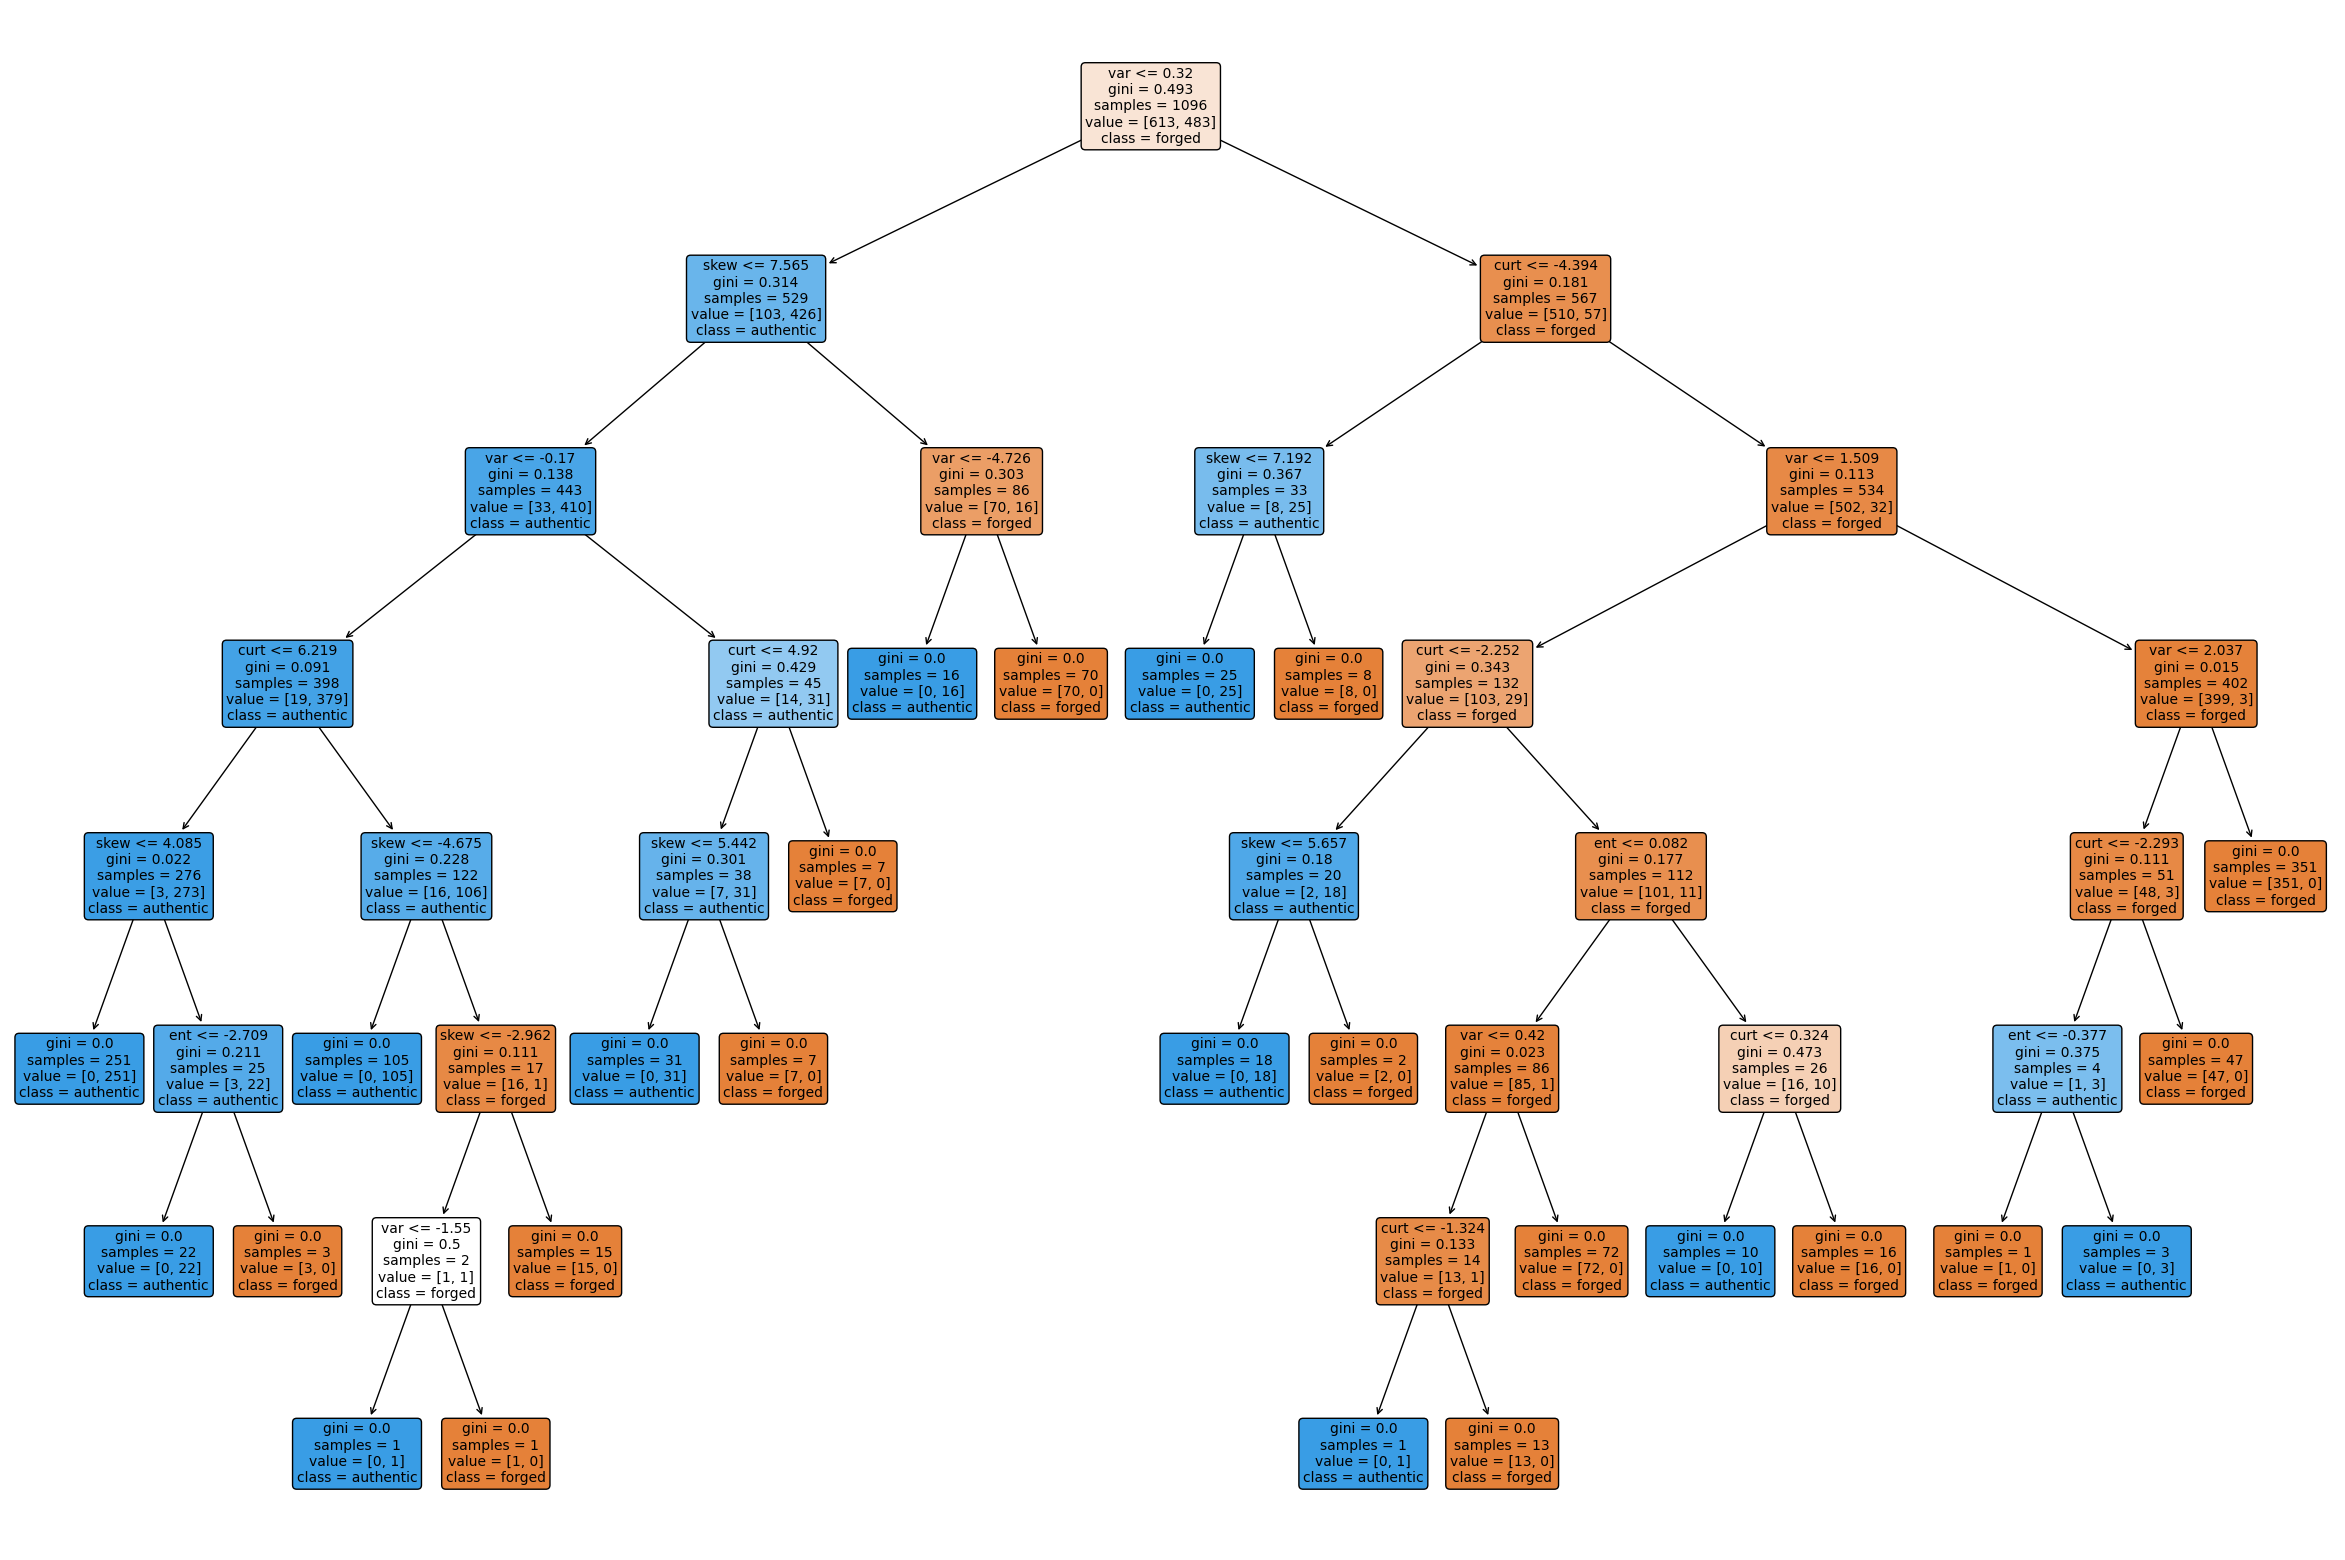

In [12]:
best_tree = DecisionTreeClassifier(criterion=best_criterion, max_depth=best_depth, min_samples_split=best_split)
best_tree.fit(X_train, y_train)
y_pred = best_tree.predict(X_test)
plotTree(best_tree)

`On Test Data`

In [13]:
criterion = ['gini', 'entropy']
max_depth = [2, 3, 4, 5, 6, 7, 8, 9, 10]
min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9, 10]
accuracies = []
max_accuracy = 0
best_criterion = None
best_depth = None
best_split = None
for crit in criterion:
    for depth in max_depth:
        for split in min_samples_split:
            accuracies.append(decision_tree(X_train, y_train, X_test, y_test, crit, depth, split))
            print("Criterion: ", crit, "\t" ,"Max Depth: ", depth,"\t"  ,"Min Samples Split: " ,split, "\t" , "Accuracy: ", decision_tree(X_train, y_train, X_test, y_test, crit, depth, split))
            if decision_tree(X_train, y_train, X_test, y_test, crit, depth, split) > max_accuracy:
                max_accuracy = decision_tree(X_train, y_train, X_test, y_test, crit, depth, split)
                best_criterion = crit
                best_depth = depth
                best_split = split

print("\n\n")
print("Max Accuracy: ", max_accuracy, "\nBest Criterion: ", best_criterion, "\nBest Depth: ", best_depth, "\nBest Split: ", best_split)

Criterion:  gini 	 Max Depth:  2 	 Min Samples Split:  2 	 Accuracy:  0.9054545454545454
Criterion:  gini 	 Max Depth:  2 	 Min Samples Split:  3 	 Accuracy:  0.9054545454545454
Criterion:  gini 	 Max Depth:  2 	 Min Samples Split:  4 	 Accuracy:  0.9054545454545454
Criterion:  gini 	 Max Depth:  2 	 Min Samples Split:  5 	 Accuracy:  0.9054545454545454
Criterion:  gini 	 Max Depth:  2 	 Min Samples Split:  6 	 Accuracy:  0.9054545454545454
Criterion:  gini 	 Max Depth:  2 	 Min Samples Split:  7 	 Accuracy:  0.9054545454545454
Criterion:  gini 	 Max Depth:  2 	 Min Samples Split:  8 	 Accuracy:  0.9054545454545454
Criterion:  gini 	 Max Depth:  2 	 Min Samples Split:  9 	 Accuracy:  0.9054545454545454
Criterion:  gini 	 Max Depth:  2 	 Min Samples Split:  10 	 Accuracy:  0.9054545454545454
Criterion:  gini 	 Max Depth:  3 	 Min Samples Split:  2 	 Accuracy:  0.9272727272727272
Criterion:  gini 	 Max Depth:  3 	 Min Samples Split:  3 	 Accuracy:  0.9272727272727272
Criterion:  gini 	 M

`Plotting Best Tree`

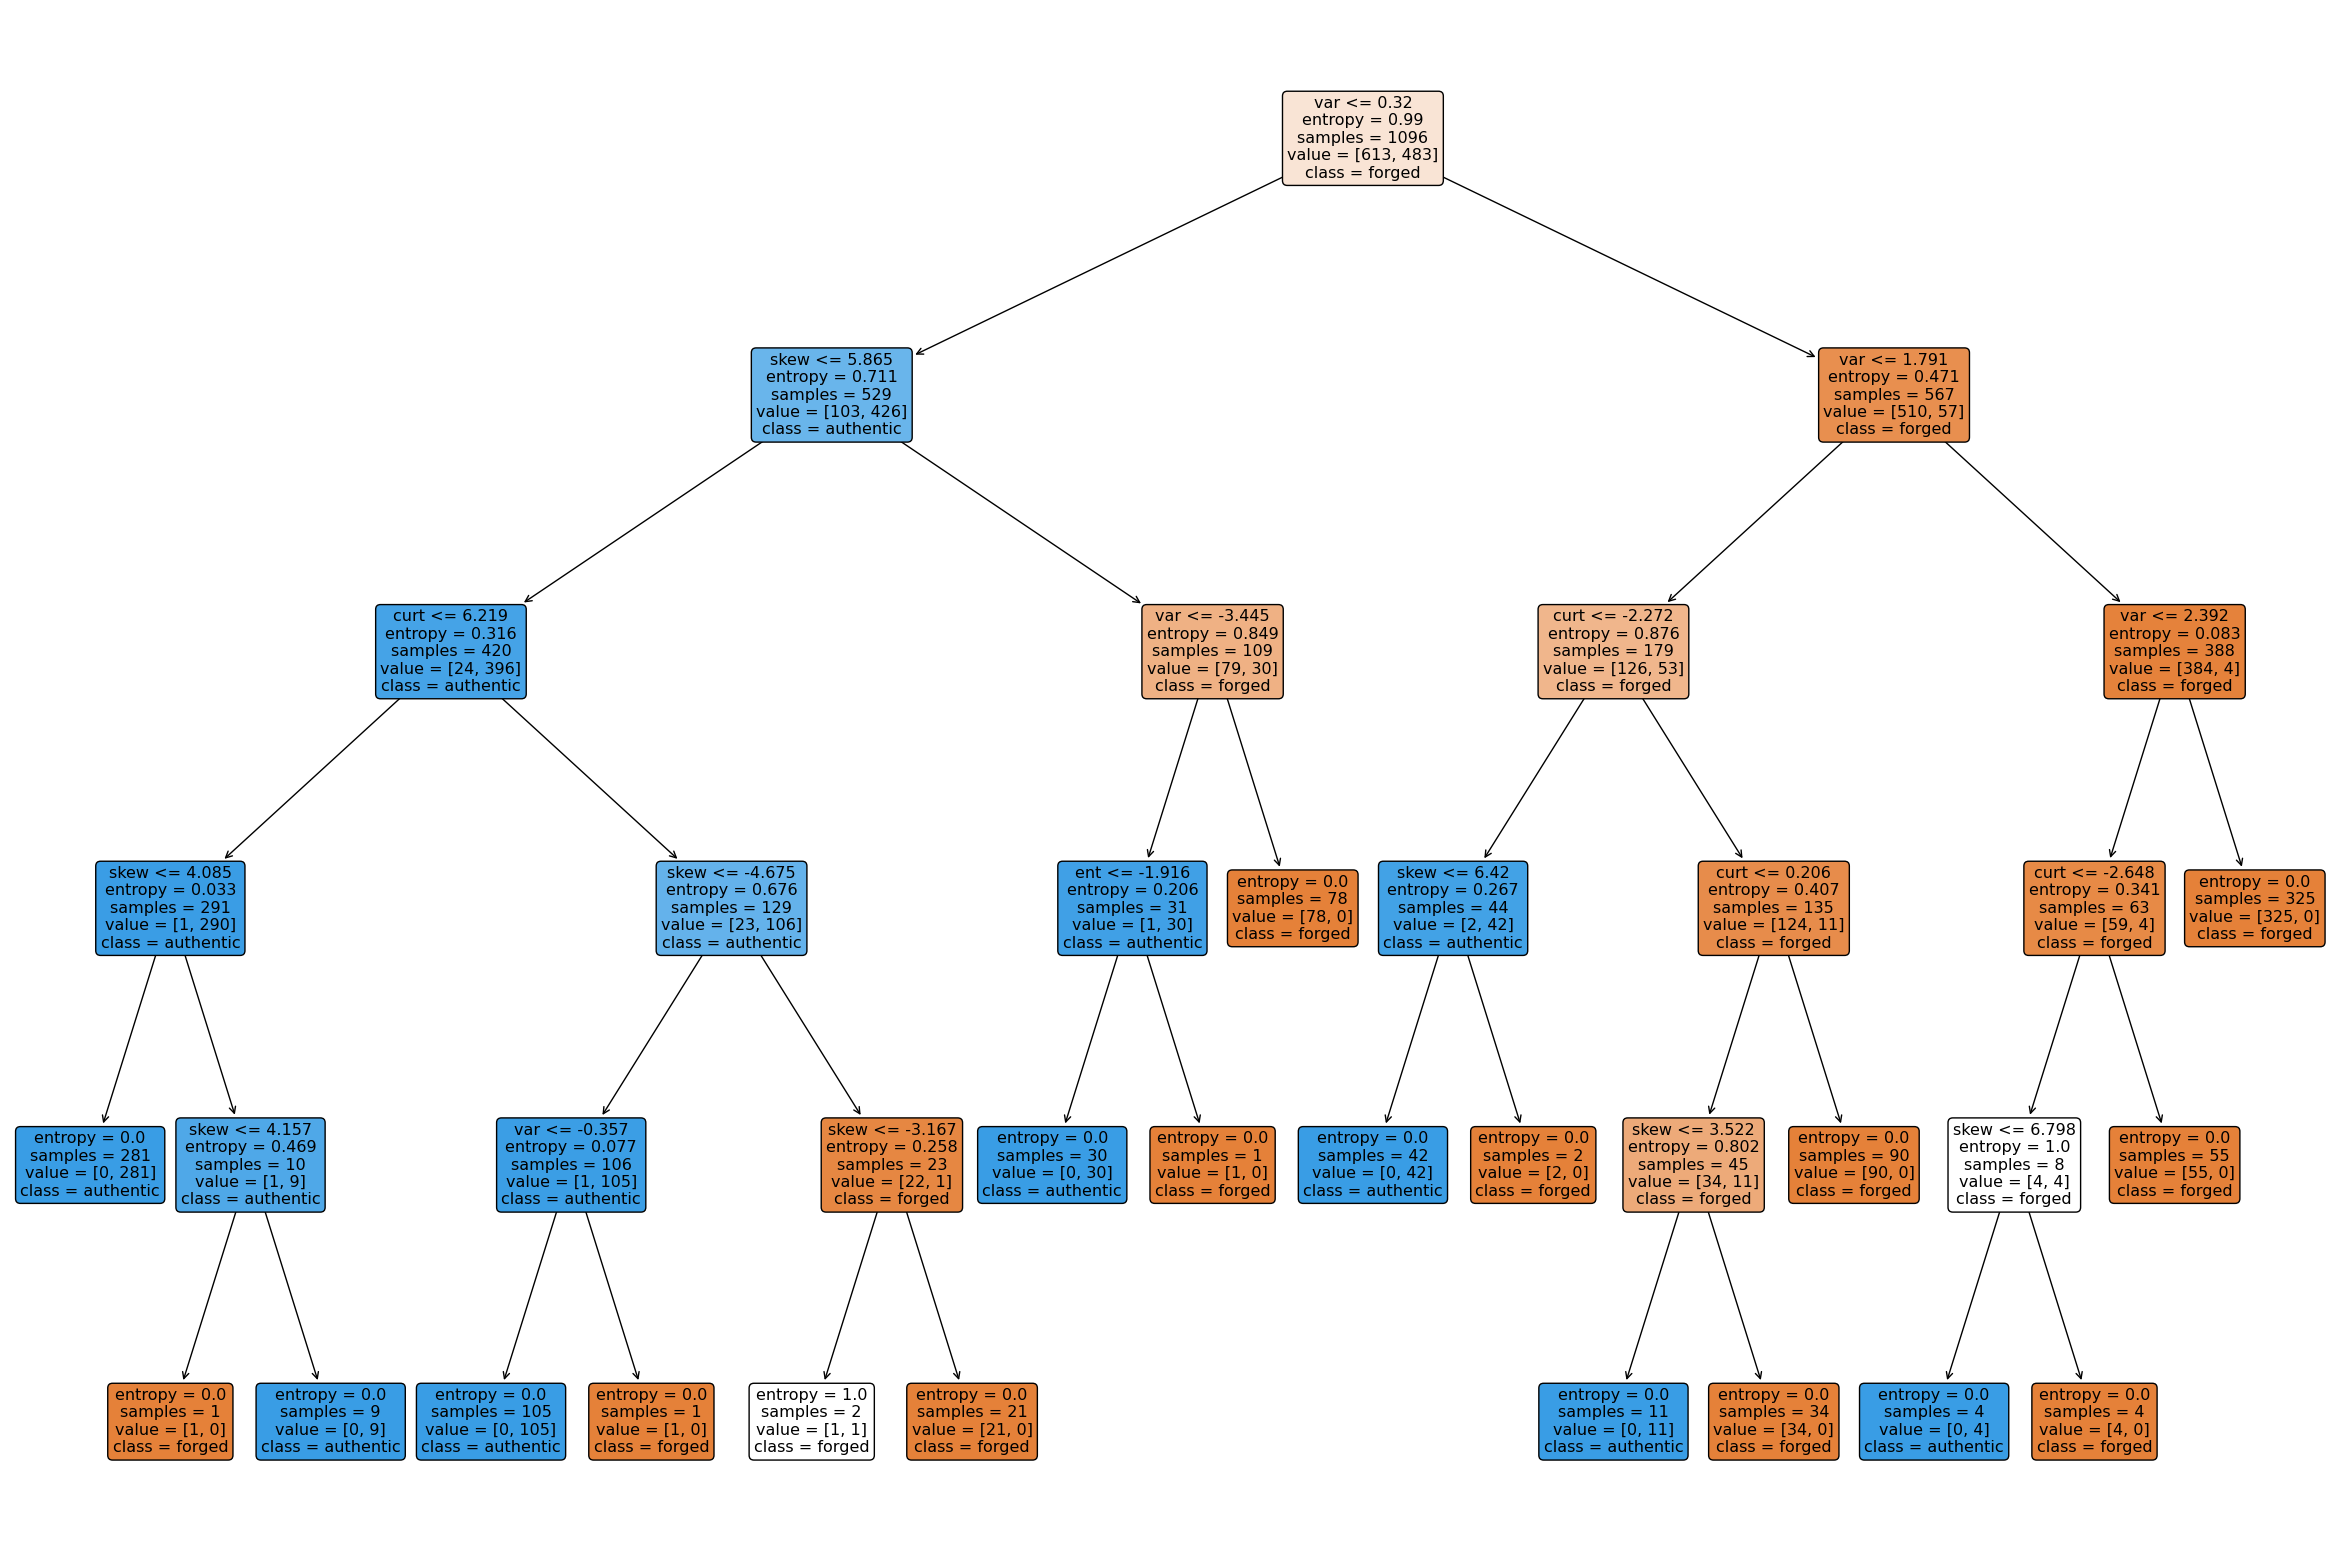

In [14]:
best_tree = DecisionTreeClassifier(criterion=best_criterion, max_depth=best_depth, min_samples_split=best_split)
best_tree.fit(X_train, y_train)
y_pred = best_tree.predict(X_test)
plotTree(best_tree)